In [1]:
# Import Library
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
from datasets import load_dataset

dataset = load_dataset("go_emotions", "raw")

Reusing dataset go_emotions (C:\Users\apria\.cache\huggingface\datasets\go_emotions\raw\0.0.0\2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
100%|██████████| 1/1 [00:00<00:00, 63.89it/s]


In [3]:
# Dataset training
train = pd.DataFrame(dataset)
train.head()

,train
0,"{'text': 'That game hurt.', 'id': 'eew5j0j', '..."
1,{'text': ' >sexuality shouldn’t be a grouping ...
2,"{'text': 'You do right, if you don't care then..."
3,"{'text': 'Man I love reddit.', 'id': 'eeibobj'..."
4,"{'text': '[NAME] was nowhere near them, he was..."


In [ ]:
train.describe()

In [9]:
# Panjang dari komentar
lens = train.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

lens.hist();

AttributeError: 'DataFrame' object has no attribute 'len'

In [5]:
train.shape[0] #rows

4

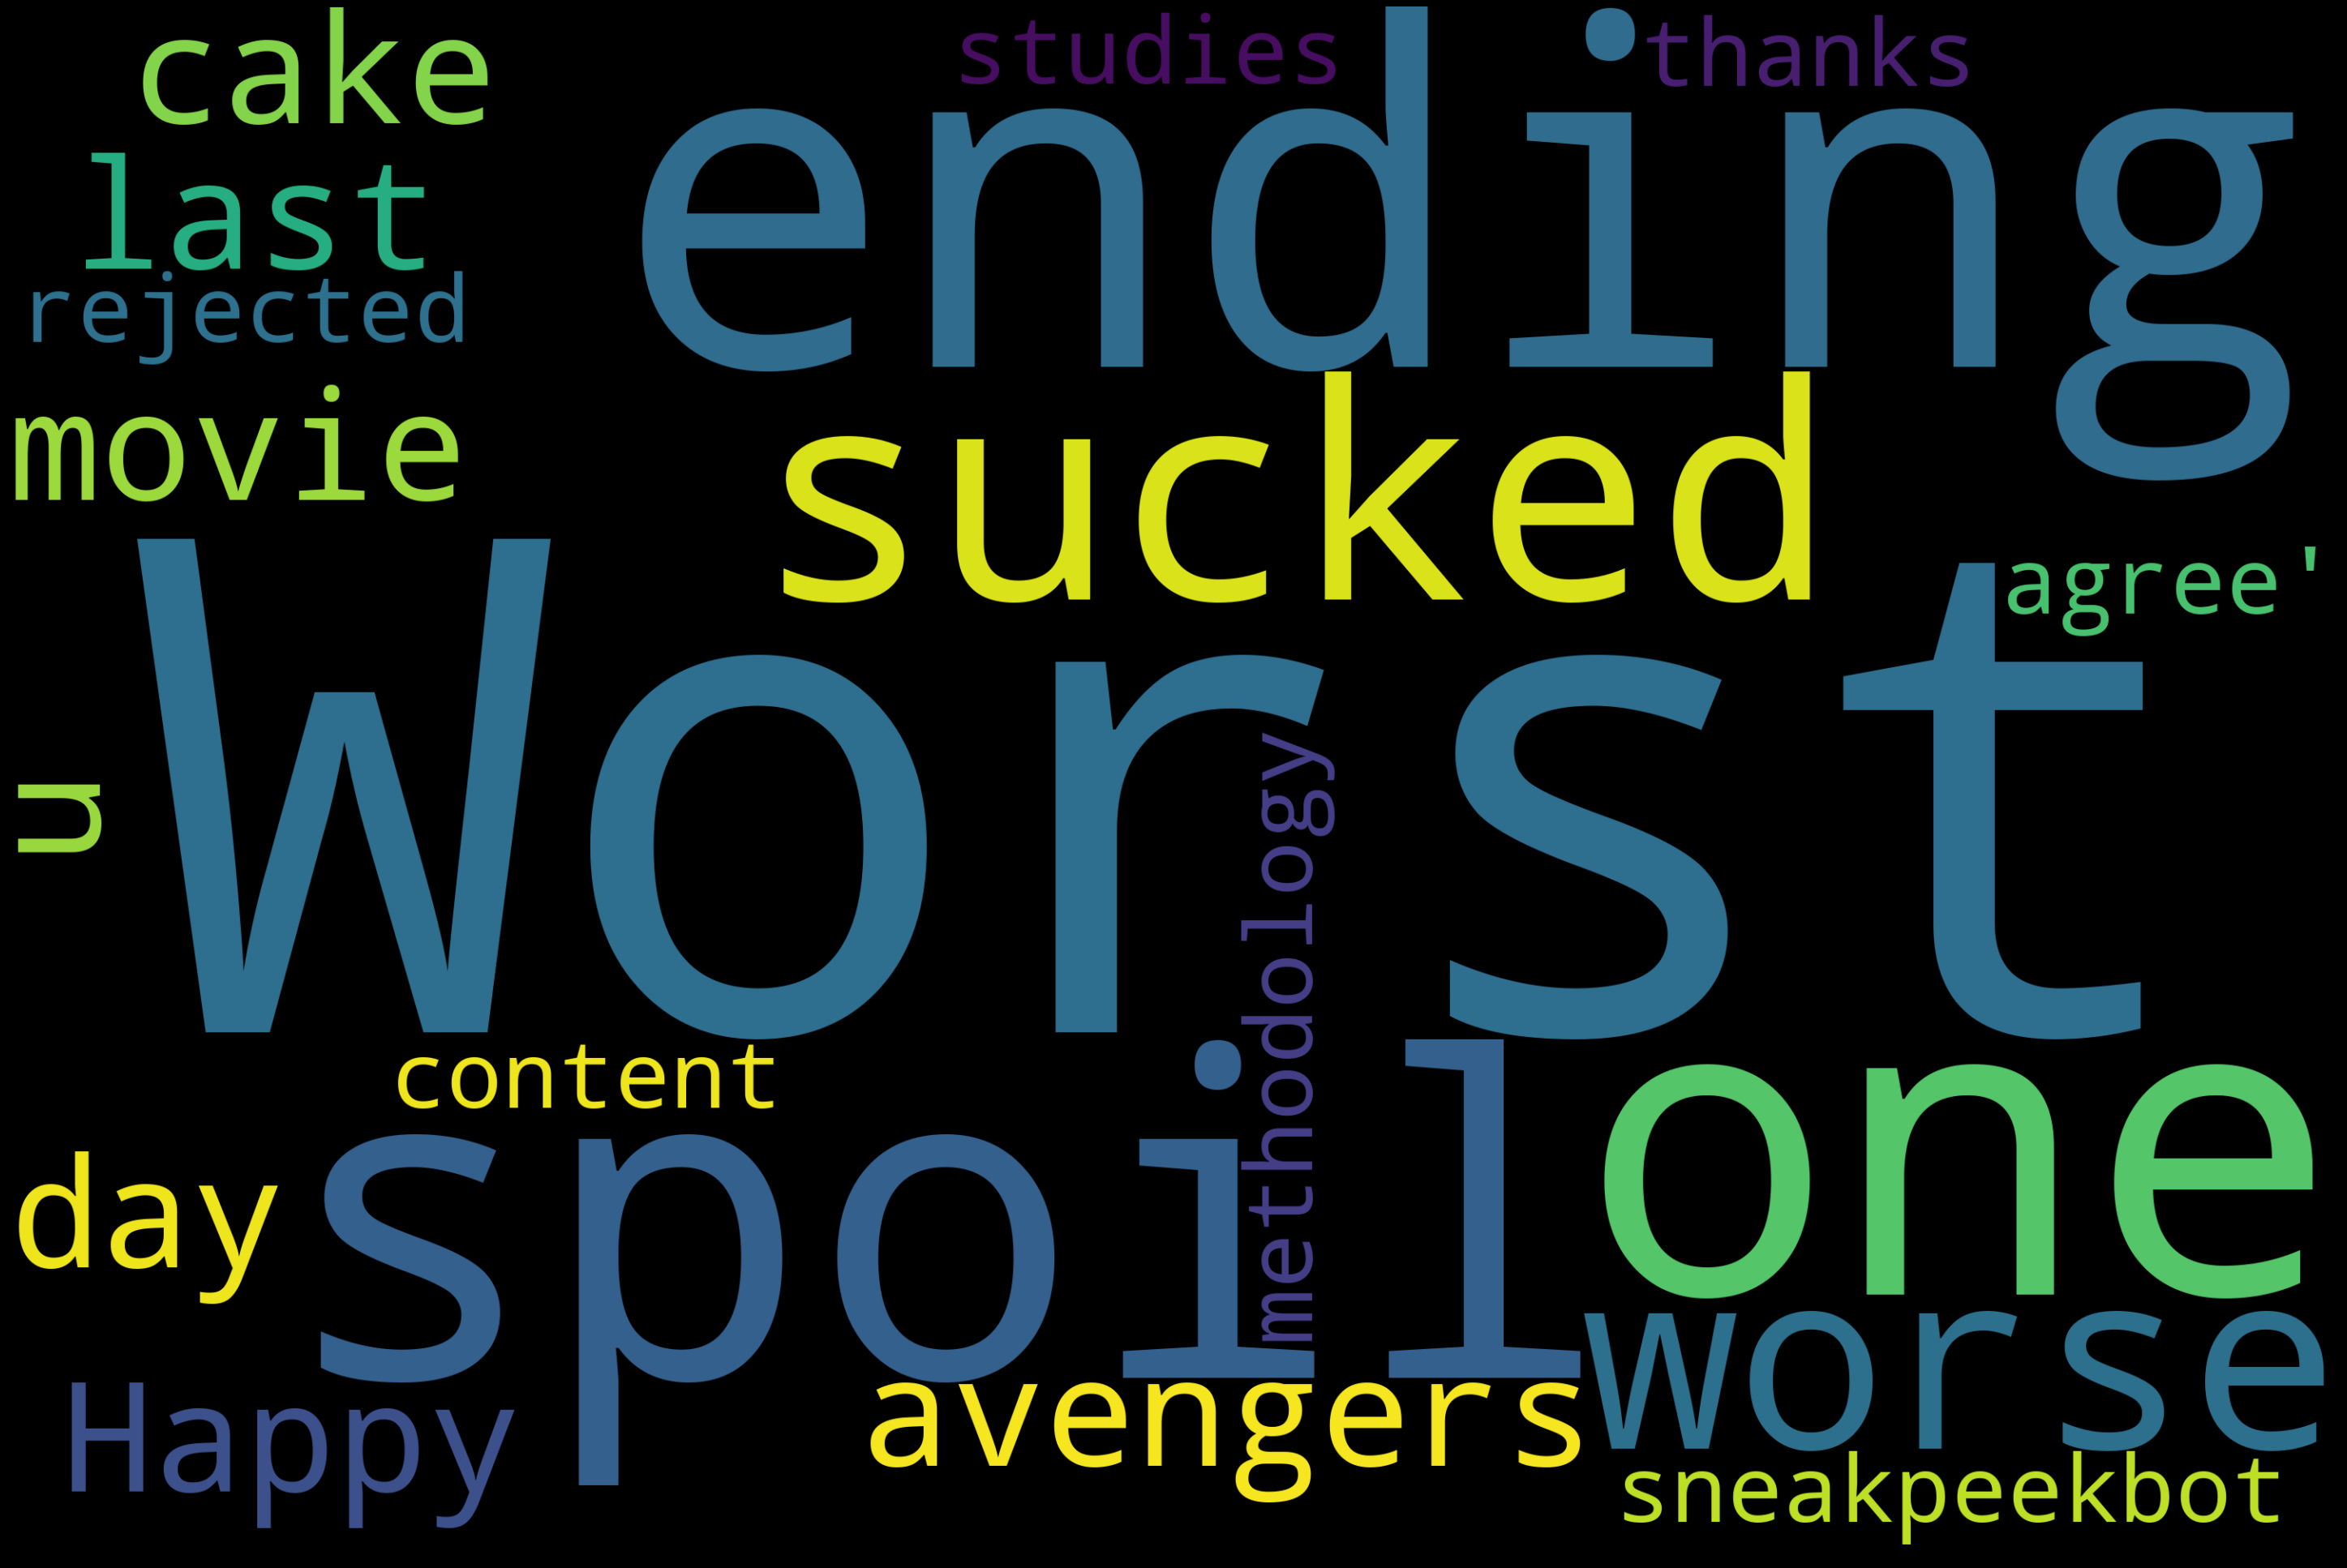

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = str(train.text.values)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black'
).generate(text)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [7]:
import re, string

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    # string which is not needed but appears frequently
    no_need = ['@', 'yang', 'dan', 'di', 'karena', 'untuk', 'juga', 'tahun', 'dr', 'atau', 'prabowo', 'jokowi']
    
    words = re_tok.sub(r' \1 ', s).split()
    return [x for x in words if not x in no_need]

In [8]:
tokenize(train.text[0])

['Worst',
 'ending',
 'ever',
 '!',
 'I',
 'won',
 "'",
 't',
 'spoil',
 'it',
 'but',
 'this',
 'one',
 'sucked',
 'worse',
 'than',
 'the',
 'avengers',
 'last',
 'movie',
 '!']

In [9]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=2, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

trn_term_doc = vec.fit_transform(train['text'])

# Use the same dataset to test
test = train
test_term_doc = vec.transform(test['text'])

In [10]:
trn_term_doc
test_term_doc

<4x3 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [11]:
df_term_doc = pd.DataFrame(trn_term_doc.toarray())
df_term_doc

,0,1,2
0,0.767495,0.453295,0.453295
1,1.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000
3,0.000000,1.000000,0.000000


In [12]:
# Basic naive bayes feature equation
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [13]:
x = trn_term_doc
test_x = test_term_doc

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=False)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [14]:
labels = ['anger', 'ending', 'ever', 'sadness', 'disgust', 'neutral', 'anticipation', 'joy']

preds = np.zeros((len(test), len(labels)))

for i, j in enumerate(labels):
   print('fit', j)
   m,r = get_mdl(train[j])
   preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]


fit anger


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
result = pd.concat([test["text"], pd.DataFrame(preds, columns = labels)], axis=1)
result

,text,anger,ending,ever,sadness,disgust,neutral,anticipation,joy
0,Worst ending ever! I won't spoil it but this o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Happy cake day u/sneakpeekbot!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Was he rejected because of his methodology or ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"thanks, I agree",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Simpan hasil yang ada pada CSV
result.to_csv('result.csv', index=False)

In [ ]:
def predict_labels(text):
    for i, j in enumerate(labels):
        print('fit', j)
        m,r = get_mdl(train[j])
        preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

IndentationError: expected an indented block (<ipython-input-40-28d11fab1f0b>, line 3)

In [ ]:
test_x

<4x3 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>